# MODULE 4

In this module, we are developing non-linear models to find the best model that fits with feature_frame CSV. We are implementing new algorithms to complete the module_3's analysis.

- Baseline
- Linear Regression
- Decision Tree
- Random Forest
- Descent Gradiente

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score, roc_auc_score, auc
from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [4]:
df = pd.read_csv('../../data/feature_frame.csv')

In [3]:
df.dropna().head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [4]:
df.columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

In [5]:
info_cols = ['variant_id', 'order_id', 'user_id', 'created_at', 'order_date']
label_col = 'outcome'
feature_cols = {col for col in df if col not in info_cols + [label_col]}

categorical_cols = ['product_type', 'vendor']
binary_cols= ['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']
numerical_cols = {col for col in feature_cols if col not in categorical_cols + binary_cols}

In [6]:
df[label_col].value_counts()

outcome
0.0    2847317
1.0      33232
Name: count, dtype: int64

In [6]:
# get those orders with more than 5 products

items_per_order = df.groupby('order_id').outcome.sum()
big_orders = items_per_order[items_per_order > 5].index

df_2 = df[df['order_id'].isin(big_orders)]

In [7]:
test_df = df_2.groupby('order_id').outcome.sum()
test_df.head(10)

order_id
2807985930372     9.0
2808027644036     6.0
2808099078276     9.0
2808393957508    13.0
2808434524292     7.0
2808548917380     7.0
2808549900420     9.0
2808728715396    12.0
2808769085572    15.0
2808786714756    16.0
Name: outcome, dtype: float64

In [8]:
df_2['order_date'] = pd.to_datetime(df_2['order_date'])

/tmp/ipykernel_1801/1778527225.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['order_date'] = pd.to_datetime(df_2['order_date'])


In [9]:
daily_orders = df_2.groupby('order_date').order_id.nunique()

daily_orders.head()

order_date
2020-10-05     3
2020-10-06     7
2020-10-07     5
2020-10-08    10
2020-10-09     4
Name: order_id, dtype: int64

Text(0.5, 1.0, 'Daily orders')

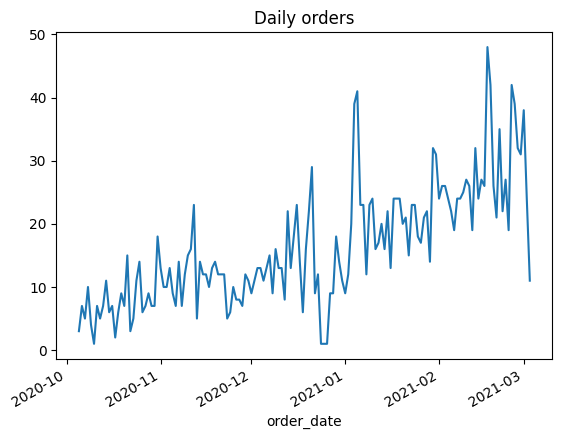

In [11]:
daily_orders.plot()
plt.title('Daily orders')

In [10]:
df_2 = df_2.sort_values(by='order_date')

In [11]:
n_total = len(df_2)
n_train = int(0.6 * n_total)
n_val = int (0.2 * n_total)

train_df = df_2[:n_train]
val_df = df_2[n_train:n_train + n_val]
test_df = df_2[n_train + n_val:]

In [12]:
predictive_cols = binary_cols + list(numerical_cols)

In [13]:
X_train = train_df[predictive_cols]
y_train = train_df[label_col]

X_val = val_df[predictive_cols]
y_val = val_df[label_col]

X_test = test_df[predictive_cols]
y_test = test_df[label_col]

In [14]:
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}, y_val shape: {y_val.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

X_train shape: (1213830, 19), y_train shape: (1213830,)
X_val shape: (404610, 19), y_val shape: (404610,)
X_test shape: (404610, 19), y_test shape: (404610,)


In [15]:
# it's not OK because we need to scale with mean and std just of the train data

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.fit_transform(X_test)

# 1. Baseline
- Let's implement a first baseline by using global_popularity

In [18]:
y_train_pred_proba = X_train['global_popularity']
y_val_pred_proba = X_val['global_popularity']

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
auc_train = auc(fpr_train, tpr_train)
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred_proba)
auc_val = auc(fpr_val, tpr_val)

precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_pred_proba)
pr_auc_train = average_precision_score(y_train, y_train_pred_proba)
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_pred_proba)
pr_auc_val = average_precision_score(y_val, y_val_pred_proba)

print(f'ROC AUC Train: {auc_train:.2f}')
print(f'ROC AUC Validation: {auc_val:.2f}')
print(f'Precision-Recall AUC Train: {pr_auc_train:.2f}')
print(f'Precision-Recall AUC Validation: {pr_auc_val:.2f}')

ROC AUC Train: 0.79
ROC AUC Validation: 0.79
Precision-Recall AUC Train: 0.06
Precision-Recall AUC Validation: 0.07


# 2. Linear Models

- Let's implement now a linear regression model
- First, with Ridge Regression with some different regularization values
- Then, with Lasso Regression also with different values.
- We're gonna see if we imporve the baseline.

In [19]:
cs = [0.0000001, 0.00001, 0.01, 1, 100, 10000, None]

for c in cs:
    model = make_pipeline(
        StandardScaler(),
        LogisticRegression(penalty='l2' if c else None, C=c if c else 1.0)
    )
    
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_val_pred = model.predict_proba(X_val)[:, 1]
    
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred)
    roc_auc_train = auc(fpr_train, tpr_train)
    roc_auc_val = auc(fpr_val, tpr_val)
    
    precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_pred)
    precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_pred)
    pr_auc_train = average_precision_score(y_train, y_train_pred)
    pr_auc_val = average_precision_score(y_val, y_val_pred)
    
    print(f'Para C = {c}:')
    print(f'  ROC AUC Train: {roc_auc_train:.2f}')
    print(f'  ROC AUC Validation: {roc_auc_val:.2f}')
    print(f'  Precision-Recall AUC Train: {pr_auc_train:.2f}')
    print(f'  Precision-Recall AUC Validation: {pr_auc_val:.2f}')
    print('-' * 50)

Para C = 1e-07:
  ROC AUC Train: 0.83
  ROC AUC Validation: 0.83
  Precision-Recall AUC Train: 0.16
  Precision-Recall AUC Validation: 0.15
--------------------------------------------------
Para C = 1e-05:
  ROC AUC Train: 0.83
  ROC AUC Validation: 0.83
  Precision-Recall AUC Train: 0.16
  Precision-Recall AUC Validation: 0.15
--------------------------------------------------
Para C = 0.01:
  ROC AUC Train: 0.80
  ROC AUC Validation: 0.81
  Precision-Recall AUC Train: 0.16
  Precision-Recall AUC Validation: 0.15
--------------------------------------------------
Para C = 1:
  ROC AUC Train: 0.80
  ROC AUC Validation: 0.81
  Precision-Recall AUC Train: 0.16
  Precision-Recall AUC Validation: 0.15
--------------------------------------------------
Para C = 100:
  ROC AUC Train: 0.80
  ROC AUC Validation: 0.81
  Precision-Recall AUC Train: 0.16
  Precision-Recall AUC Validation: 0.15
--------------------------------------------------
Para C = 10000:
  ROC AUC Train: 0.80
  ROC AUC Vali

Ridge best => alpha = 1e-07

Now, let's try Lasso

In [20]:
cs = [0.0000001, 0.00001, 0.01, 1, 100, 10000, None]

for c in cs:
    model = make_pipeline(
        StandardScaler(),
        LogisticRegression(penalty='l1' if c else None, C=c if c else 1.0, solver='saga')
    )
    
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_val_pred = model.predict_proba(X_val)[:, 1]
    
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred)
    roc_auc_train = auc(fpr_train, tpr_train)
    roc_auc_val = auc(fpr_val, tpr_val)
    
    precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_pred)
    precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_pred)
    pr_auc_train = average_precision_score(y_train, y_train_pred)
    pr_auc_val = average_precision_score(y_val, y_val_pred)
    
    print(f'Para C = {c}:')
    print(f'  ROC AUC Train: {roc_auc_train:.2f}')
    print(f'  ROC AUC Validation: {roc_auc_val:.2f}')
    print(f'  Precision-Recall AUC Train: {pr_auc_train:.2f}')
    print(f'  Precision-Recall AUC Validation: {pr_auc_val:.2f}')
    print('-' * 50)

Para C = 1e-07:
  ROC AUC Train: 0.50
  ROC AUC Validation: 0.50
  Precision-Recall AUC Train: 0.02
  Precision-Recall AUC Validation: 0.01
--------------------------------------------------
Para C = 1e-05:
  ROC AUC Train: 0.50
  ROC AUC Validation: 0.50
  Precision-Recall AUC Train: 0.02
  Precision-Recall AUC Validation: 0.01
--------------------------------------------------
Para C = 0.01:
  ROC AUC Train: 0.80
  ROC AUC Validation: 0.81
  Precision-Recall AUC Train: 0.16
  Precision-Recall AUC Validation: 0.15
--------------------------------------------------
Para C = 1:
  ROC AUC Train: 0.80
  ROC AUC Validation: 0.81
  Precision-Recall AUC Train: 0.16
  Precision-Recall AUC Validation: 0.15
--------------------------------------------------
Para C = 100:
  ROC AUC Train: 0.80
  ROC AUC Validation: 0.81
  Precision-Recall AUC Train: 0.16
  Precision-Recall AUC Validation: 0.15
--------------------------------------------------
Para C = 10000:
  ROC AUC Train: 0.80
  ROC AUC Vali

- Very small values in Lasso regularization lead to poor results. 
- Starting from 0.01, the values become similar to Ridge, but Ridge is a little bit better.
- Additionally, as observed, this regularization doesn't contribute much, and without it, we achieve very similar results. 
- Therefore, it might be a better option to apply linear regression without regularization, as we obtain almost identical results without the need for any additional techniques.
- The dataset is large enough to don't need any regularization

                             Feature  Ridge Coef  Lasso Coef
1                   abandoned_before    0.022370    0.013324
0                     ordered_before    0.020805    0.012507
8                  global_popularity    0.014860    0.006563
3                     set_as_regular    0.003956    0.000000
16                    user_order_seq   -0.001588   -0.000000
12  days_since_purchase_product_type    0.001290    0.000000
9     days_since_purchase_variant_id   -0.001157   -0.000000
15                  normalised_price   -0.000886   -0.000000
14      avg_days_to_buy_product_type   -0.000792   -0.000000
10        std_days_to_buy_variant_id   -0.000789   -0.000000
18        avg_days_to_buy_variant_id   -0.000707   -0.000000
5                         count_pets    0.000468    0.000000
7                       discount_pct    0.000314    0.000000
17                      count_adults    0.000234    0.000000
13      std_days_to_buy_product_type    0.000229   -0.000000
2                     ac

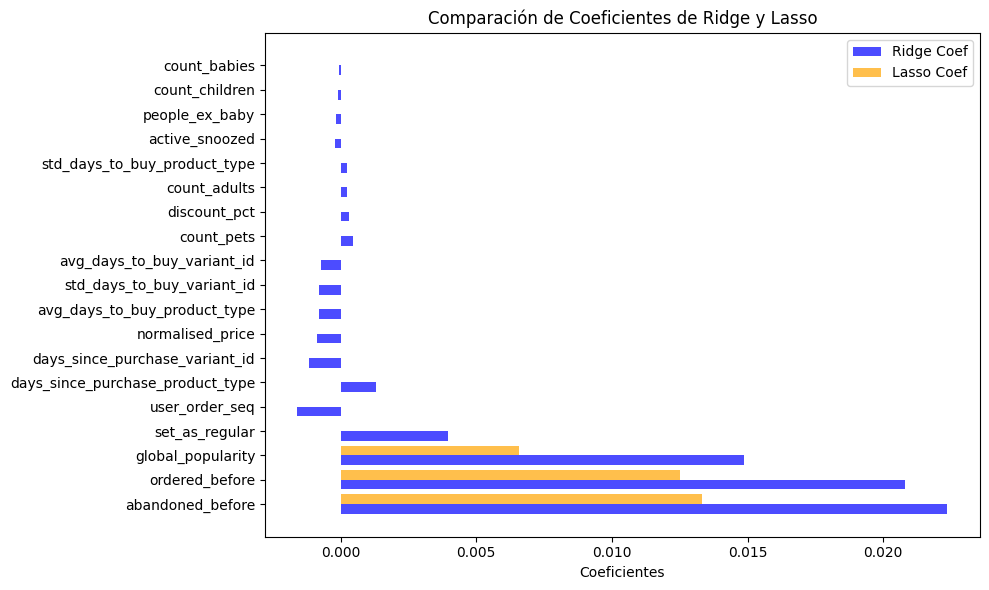

In [21]:
alpha_ridge = 1e-07
alpha_lasso = 0.01

ridge = make_pipeline(StandardScaler(), Ridge(alpha=alpha_ridge)) 
lasso = make_pipeline(StandardScaler(), Lasso(alpha=alpha_lasso))

ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

ridge_coef = ridge.named_steps['ridge'].coef_
lasso_coef = lasso.named_steps['lasso'].coef_

coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Ridge Coef': ridge_coef,
    'Lasso Coef': lasso_coef
})

coef_df['Abs Ridge Coef'] = np.abs(coef_df['Ridge Coef'])
coef_df['Abs Lasso Coef'] = np.abs(coef_df['Lasso Coef'])
coef_df = coef_df.sort_values(by=['Abs Ridge Coef', 'Abs Lasso Coef'], ascending=False)

print(coef_df[['Feature', 'Ridge Coef', 'Lasso Coef']])

plt.figure(figsize=(10, 6))

bar_width = 0.4  
index = np.arange(len(coef_df))

plt.barh(index - bar_width/2, coef_df['Ridge Coef'], bar_width, color='blue', alpha=0.7, label='Ridge Coef')

plt.barh(index + bar_width/2, coef_df['Lasso Coef'], bar_width, color='orange', alpha=0.7, label='Lasso Coef')

plt.xlabel('Coeficientes')
plt.title('Comparación de Coeficientes de Ridge y Lasso')
plt.yticks(index, coef_df['Feature'])
plt.legend()

plt.tight_layout()
plt.show()

- Lasso only uses three features, and Ridge uses mainly the same three. We can try to develop a model by using just this three features

In [17]:
top_cols = ['abandoned_before', 'ordered_before', 'global_popularity']

In [18]:
X_train_top = X_train[top_cols]
X_val_top = X_val[top_cols]

In [20]:
alpha_ridge = 1e-07

ridge = make_pipeline(StandardScaler(), Ridge(alpha=alpha_ridge))
ridge.fit(X_train_top, y_train)

y_train_pred = ridge.predict(X_train_top)
y_val_pred = ridge.predict(X_val_top)

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred)
roc_auc_val = auc(fpr_val, tpr_val)

precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_pred)
pr_auc_train = auc(recall_train, precision_train)

precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_pred)
pr_auc_val = auc(recall_val, precision_val)

print(f"Ridge Regression with alpha = {alpha_ridge}")
print(f"ROC AUC for Train: {roc_auc_train:.2f}")
print(f"ROC AUC for Validation: {roc_auc_val:.2f}")
print(f"PR AUC for Train: {pr_auc_train:.2f}")
print(f"PR AUC for Validation: {pr_auc_val:.2f}")

Ridge Regression with alpha = 1e-07
ROC AUC for Train: 0.83
ROC AUC for Validation: 0.83
PR AUC for Train: 0.17
PR AUC for Validation: 0.14


- We find that with less features we get the same results. Because Lasso and Ridge have similar results (but Ridge a little bit better) we set Ridge with 1e-07 regularization as the best option.
- We can also try to include some categorical features

BEST LINEAR MODEL => Ridge (alpha = 1e-07) with top_cols

# Non-linear models

Now that we've got better results with a linear regression than the baseline, let's see if we can improve it by using different non-linear models

# 3. Decision tree

We are gonna try to get better metrics by trying to implement decision trees with different max_depth values

In [29]:
max_depth_values = [1, 2, 4, 8, 12, 20]
roc_auc_train = []
roc_auc_val = []
pr_auc_train = []
pr_auc_val = []

for depth in max_depth_values:
    tree_clf = DecisionTreeClassifier(max_depth=depth, random_state=42)

    tree_clf.fit(X_train, y_train)

    y_train_pred_proba = tree_clf.predict_proba(X_train)[:, 1]
    y_val_pred_proba = tree_clf.predict_proba(X_val)[:, 1]

    roc_auc_train.append(roc_auc_score(y_train, y_train_pred_proba))
    roc_auc_val.append(roc_auc_score(y_val, y_val_pred_proba))

    pr_auc_train.append(average_precision_score(y_train, y_train_pred_proba))
    pr_auc_val.append(average_precision_score(y_val, y_val_pred_proba))

for depth, train_roc_auc, val_roc_auc, train_pr_auc, val_pr_auc in zip(max_depth_values, roc_auc_train, roc_auc_val, pr_auc_train, pr_auc_val):
    print(f"max_depth = {depth}:")
    print(f"  ROC AUC Train: {train_roc_auc:.4f}")
    print(f"  ROC AUC Val: {val_roc_auc:.4f}")
    print(f"  PR AUC Train: {train_pr_auc:.4f}")
    print(f"  PR AUC Val: {val_pr_auc:.4f}")
    print('-' * 50)

max_depth = 1:
  ROC AUC Train: 0.5248
  ROC AUC Val: 0.5099
  PR AUC Train: 0.0536
  PR AUC Val: 0.0266
--------------------------------------------------
max_depth = 2:
  ROC AUC Train: 0.6453
  ROC AUC Val: 0.6477
  PR AUC Train: 0.0993
  PR AUC Val: 0.0764
--------------------------------------------------
max_depth = 4:
  ROC AUC Train: 0.8145
  ROC AUC Val: 0.8133
  PR AUC Train: 0.1509
  PR AUC Val: 0.1258
--------------------------------------------------
max_depth = 8:
  ROC AUC Train: 0.8359
  ROC AUC Val: 0.8255
  PR AUC Train: 0.1975
  PR AUC Val: 0.1285
--------------------------------------------------
max_depth = 12:
  ROC AUC Train: 0.8466
  ROC AUC Val: 0.8047
  PR AUC Train: 0.2454
  PR AUC Val: 0.0966
--------------------------------------------------
max_depth = 20:
  ROC AUC Train: 0.9063
  ROC AUC Val: 0.6632
  PR AUC Train: 0.4480
  PR AUC Val: 0.0543
--------------------------------------------------


# 4. Random Forest

Now, let's implement Random Forest with different n_estimators values 

In [31]:
n_estimators_values = [10, 20, 50, 100]

for n_estimators in n_estimators_values:
    rf_clf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf_clf.fit(X_train, y_train)

    y_train_proba = rf_clf.predict_proba(X_train)[:, 1]
    y_val_proba = rf_clf.predict_proba(X_val)[:, 1]

    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
    roc_auc_train = auc(fpr_train, tpr_train)

    precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_proba)
    pr_auc_train = auc(recall_train, precision_train)

    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba)
    roc_auc_val = auc(fpr_val, tpr_val)

    precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_proba)
    pr_auc_val = auc(recall_val, precision_val)

    print(f"n_estimators = {n_estimators}:")
    print(f"  Train ROC AUC: {roc_auc_train:.4f}")
    print(f"  Validation ROC AUC: {roc_auc_val:.4f}")
    print(f"  Train Precision-Recall AUC: {pr_auc_train:.4f}")
    print(f"  Validation Precision-Recall AUC: {pr_auc_val:.4f}")
    print('-' * 50)

n_estimators = 10:
  Train ROC AUC: 0.9942
  Validation ROC AUC: 0.6792
  Train Precision-Recall AUC: 0.8330
  Validation Precision-Recall AUC: 0.1063
--------------------------------------------------
n_estimators = 20:
  Train ROC AUC: 0.9953
  Validation ROC AUC: 0.7053
  Train Precision-Recall AUC: 0.8560
  Validation Precision-Recall AUC: 0.1138
--------------------------------------------------
n_estimators = 50:
  Train ROC AUC: 0.9958
  Validation ROC AUC: 0.7345
  Train Precision-Recall AUC: 0.8675
  Validation Precision-Recall AUC: 0.1181
--------------------------------------------------
n_estimators = 100:
  Train ROC AUC: 0.9959
  Validation ROC AUC: 0.7509
  Train Precision-Recall AUC: 0.8706
  Validation Precision-Recall AUC: 0.1194
--------------------------------------------------


- Seems that there is so much variance, a low number of trees gives a very high error, so maybe it is necessary to add more trees.
- Let's try to remove features with less importance

In [22]:
rf = RandomForestClassifier(100)
rf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
print(f"Feature importances: {len(importances)}")
print(f"Adjusted predictive cols: {len(adjusted_predictive_cols)}")

Feature importances: 19
Adjusted predictive cols: 19


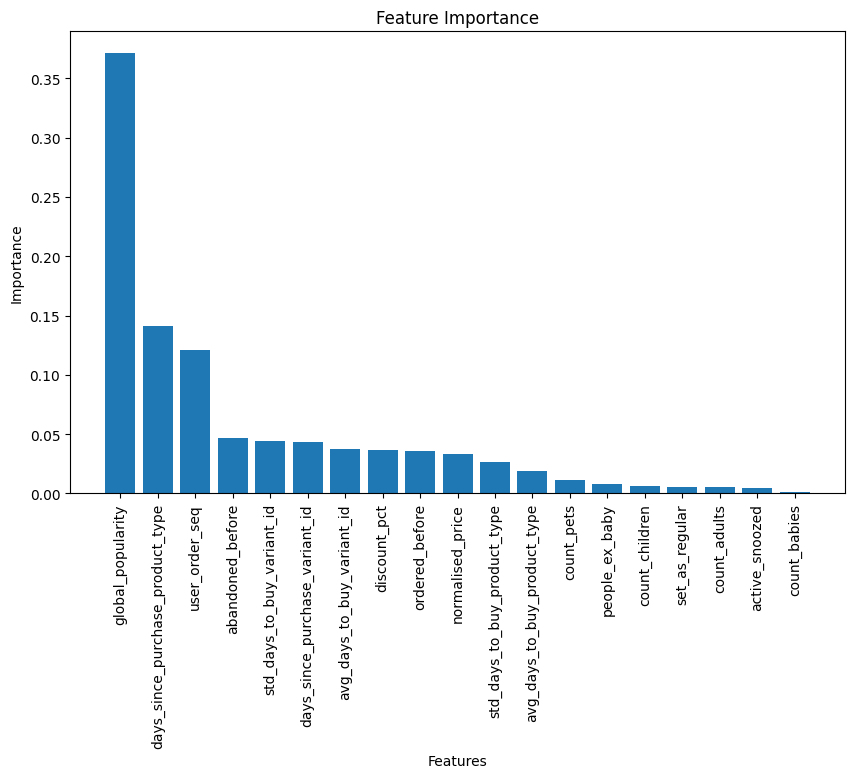

In [35]:
importances = rf.feature_importances_
index = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(predictive_cols)), importances[index], align="center")
plt.xticks(range(len(predictive_cols)), np.array(predictive_cols)[index], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance")
plt.show()

In [ ]:
filtered_cols = np.array(predictive_cols)[index[:15]]

In [39]:
n_estimators_values = [10, 20, 50, 100]

for n_estimators in n_estimators_values:
    rf_clf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf_clf.fit(X_train[filtered_cols], y_train)

    y_train_proba = rf_clf.predict_proba(X_train[filtered_cols])[:, 1]
    y_val_proba = rf_clf.predict_proba(X_val[filtered_cols])[:, 1]

    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
    roc_auc_train = auc(fpr_train, tpr_train)

    precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_proba)
    pr_auc_train = auc(recall_train, precision_train)

    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba)
    roc_auc_val = auc(fpr_val, tpr_val)

    precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_proba)
    pr_auc_val = auc(recall_val, precision_val)

    print(f"n_estimators = {n_estimators}:")
    print(f"  Train ROC AUC: {roc_auc_train:.4f}")
    print(f"  Validation ROC AUC: {roc_auc_val:.4f}")
    print(f"  Train Precision-Recall AUC: {pr_auc_train:.4f}")
    print(f"  Validation Precision-Recall AUC: {pr_auc_val:.4f}")
    print('-' * 50)

n_estimators = 10:
  Train ROC AUC: 0.9936
  Validation ROC AUC: 0.6627
  Train Precision-Recall AUC: 0.8172
  Validation Precision-Recall AUC: 0.0881
--------------------------------------------------
n_estimators = 20:
  Train ROC AUC: 0.9947
  Validation ROC AUC: 0.6908
  Train Precision-Recall AUC: 0.8411
  Validation Precision-Recall AUC: 0.0956
--------------------------------------------------
n_estimators = 50:
  Train ROC AUC: 0.9953
  Validation ROC AUC: 0.7231
  Train Precision-Recall AUC: 0.8536
  Validation Precision-Recall AUC: 0.1014
--------------------------------------------------
n_estimators = 100:
  Train ROC AUC: 0.9955
  Validation ROC AUC: 0.7383
  Train Precision-Recall AUC: 0.8569
  Validation Precision-Recall AUC: 0.1029
--------------------------------------------------


- With so much features a single tree could receive only 'bad' features
- By now, we are not beating Linear Regression

# 5. Gradient Boosting Trees

- Could be used n_iter_no_change??

In [40]:
learning_rates = [0.05, 0.1]
n_estimators_list = [5, 10, 50, 100]
max_depth_values = [1, 3, 5]

for lr in learning_rates:
    for depth in max_depth_values:
        for n_trees in n_estimators_list:
            gbt = GradientBoostingClassifier(learning_rate=lr, max_depth=depth, n_estimators=n_trees)
            
            gbt.fit(X_train, y_train)
            
            y_train_prob = gbt.predict_proba(X_train)[:, 1]
            y_val_prob = gbt.predict_proba(X_val)[:, 1]
            
            train_roc_auc = roc_auc_score(y_train, y_train_prob)
            val_roc_auc = roc_auc_score(y_val, y_val_prob)
            
            train_ap = average_precision_score(y_train, y_train_prob)
            val_ap = average_precision_score(y_val, y_val_prob)
            
            print(f"LR={lr}, Depth={depth}, Estimators={n_trees} => "
                  f"Train ROC AUC={train_roc_auc:.4f}, Val ROC AUC={val_roc_auc:.4f}, "
                  f"Train PR AUC={train_ap:.4f}, Val PR AUC={val_ap:.4f}")


LR=0.05, Depth=1, Estimators=5 => Train ROC AUC=0.6453, Val ROC AUC=0.6477, Train PR AUC=0.0938, Val PR AUC=0.0728
LR=0.05, Depth=1, Estimators=10 => Train ROC AUC=0.6453, Val ROC AUC=0.6477, Train PR AUC=0.0938, Val PR AUC=0.0728
LR=0.05, Depth=1, Estimators=50 => Train ROC AUC=0.8191, Val ROC AUC=0.8156, Train PR AUC=0.1592, Val PR AUC=0.1384
LR=0.05, Depth=1, Estimators=100 => Train ROC AUC=0.8289, Val ROC AUC=0.8317, Train PR AUC=0.1701, Val PR AUC=0.1558
LR=0.05, Depth=3, Estimators=5 => Train ROC AUC=0.7807, Val ROC AUC=0.7670, Train PR AUC=0.1555, Val PR AUC=0.1345
LR=0.05, Depth=3, Estimators=10 => Train ROC AUC=0.7986, Val ROC AUC=0.7847, Train PR AUC=0.1635, Val PR AUC=0.1426
LR=0.05, Depth=3, Estimators=50 => Train ROC AUC=0.8354, Val ROC AUC=0.8410, Train PR AUC=0.1968, Val PR AUC=0.1781
LR=0.05, Depth=3, Estimators=100 => Train ROC AUC=0.8389, Val ROC AUC=0.8433, Train PR AUC=0.2036, Val PR AUC=0.1788
LR=0.05, Depth=5, Estimators=5 => Train ROC AUC=0.8336, Val ROC AUC=0.83

In [1]:
lr_best = 0.1
max_depth_best = 3
n_trees_best = 50

- By using GBT, we achieve better results than the others by using the same metrics, so in this case we are setting GBT as the best option of all them. 
- As we need so much compute time, we are not doing more tests on GBT.
- We set GBT with hyperparameters (0.1, 3, 50) as the best model.

- It would be a good option to try other GBT, as catboost or XGBoost.

# COMPARING MODELS

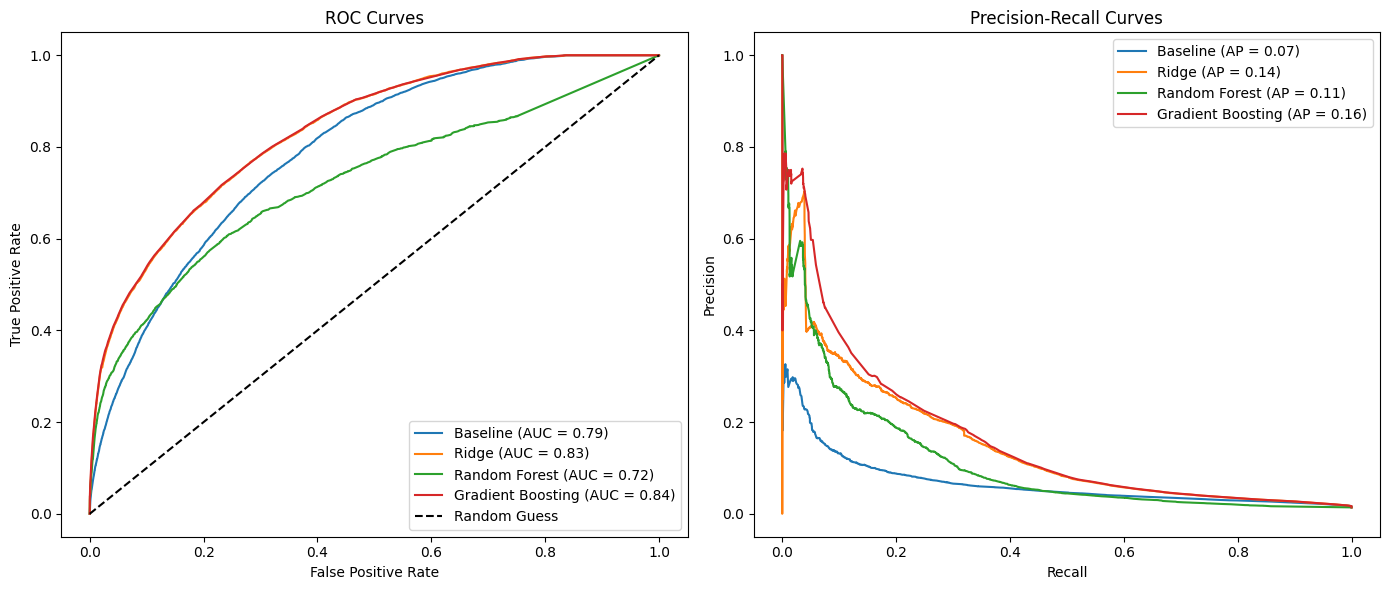

In [22]:
models = {
    "Baseline": None,
    "Ridge": make_pipeline(StandardScaler(),
                           LogisticRegression(penalty='l2', C=1e-07, solver='saga')),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Gradient Boosting": GradientBoostingClassifier(learning_rate=0.1, max_depth=3, n_estimators=50)
}

roc_curves = {}
pr_curves = {}
aucs_roc = {}
aucs_pr = {}

for name, model in models.items():
    if name == "Baseline":
        y_train_pred = X_train["global_popularity"]
        y_val_pred = X_val["global_popularity"]
    else:
        model.fit(X_train[top_cols], y_train)
        y_train_pred = model.decision_function(X_train[top_cols]) if hasattr(model, "decision_function") else model.predict_proba(X_train[top_cols])[:, 1]
        y_val_pred = model.decision_function(X_val[top_cols]) if hasattr(model, "decision_function") else model.predict_proba(X_val[top_cols])[:, 1]
    
    fpr, tpr, _ = roc_curve(y_val, y_val_pred)
    roc_auc = auc(fpr, tpr)
    roc_curves[name] = (fpr, tpr)
    aucs_roc[name] = roc_auc
    
    precision, recall, _ = precision_recall_curve(y_val, y_val_pred)
    pr_auc = average_precision_score(y_val, y_val_pred)
    pr_curves[name] = (recall, precision)
    aucs_pr[name] = pr_auc

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for name, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC = {aucs_roc[name]:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.subplot(1, 2, 2)
for name, (recall, precision) in pr_curves.items():
    plt.plot(recall, precision, label=f"{name} (AP = {aucs_pr[name]:.2f})")
plt.title("Precision-Recall Curves")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

plt.tight_layout()
plt.show()

- In this graph, we can see that GBT seems to be the best model, even by using the 'top_cols', so we are choosing GBT with top_cols.

# OUTCOME

We have seen that:
- Gradient Boosting Tree performs the best.
- Logistic Regression gives great results with lower complexity.
- Regularisation helps to improve the model.
- We can achieve same results by using just a few features.
- We've used AUC and AP metrics as are stronger than others as score.
- We've dome temporalry split because the data is splitted over time.



- Categorical features were not used as we felt that this extra complexity does not worth it. (it'd be a good option to try catboost algorithm)